In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def analyse_sample_data(file_name):
    df_bsp1 = pd.read_excel(f'C:/Users/YC/PycharmProjects/nitrateAnalysis/lineg_data/{file_name}', header=[14, 15])
    print(f'Name of the file: {file_name}')
    df_bsp1.columns = df_bsp1.columns.droplevel(1)  # getting rid of multiindex
    df_bsp1_reduced = df_bsp1[['Probenahmedatum', 'Nitrat (NO#3#)']]
    df_bsp1_reduced.insert(0, "SiteId", 1, True)
    df_bsp1_reduced = df_bsp1_reduced.iloc[: -3]
    # the date in the dataset is in the str format, that is why it is transformed to the datetime
    df_bsp1_reduced['Probenahmedatum'] = pd.to_datetime(df_bsp1_reduced['Probenahmedatum'],
                                                        format='%d.%m.%Y')
    # .dt.date
    min_date = df_bsp1_reduced['Probenahmedatum'].min()
    max_date = df_bsp1_reduced['Probenahmedatum'].max()
    years_total = relativedelta(max_date, min_date).years
    print(f"Min date is {min_date.date()}.")
    print(f"Max date is {max_date.date()}.")
    print(f"Total number of years discovered: {years_total}.")
    #
    series_month_grouped = df_bsp1_reduced.groupby(df_bsp1_reduced.Probenahmedatum.dt.month)["Nitrat (NO#3#)"].count()
    df_month_grouped = pd.DataFrame({'Month': series_month_grouped.index,
                                     'Number of measurements taken': series_month_grouped.values})
    #
    ax = sns.barplot(x='Month', y='Number of measurements taken',
                     data=df_month_grouped,
                     errwidth=0,
                     )

    for i in ax.containers:
        ax.bar_label(i, )

    ax.set_title(f'Total Number of Samples Taken per Month over {min_date.date()}--{max_date.date()}')
    plt.show()
    #
    series_year_month_grouped = df_bsp1_reduced.groupby([df_bsp1_reduced.Probenahmedatum.dt.year,
                                                         df_bsp1_reduced.Probenahmedatum.dt.month])[
                                                         "Nitrat (NO#3#)"].count()
    mean_samples_year_month = series_year_month_grouped.values.mean()
    min_samples_year_month = series_year_month_grouped.values.min()
    max_samples_year_month = series_year_month_grouped.values.max()
    sd_samples_year_month = series_year_month_grouped.values.std()

    print(f"Min number of samples taken per 1 month: {min_samples_year_month}.")
    print(f"Max number of samples taken per 1 month {max_samples_year_month}.")
    print(f"Mean number of samples taken per 1 month: {mean_samples_year_month}.")
    #
    series_year_grouped = df_bsp1_reduced.groupby([df_bsp1_reduced.Probenahmedatum.dt.year])["Nitrat (NO#3#)"].count()

    mean_samples_year = series_year_grouped.values.mean()
    min_samples_year = series_year_grouped.values.min()
    max_samples_year = series_year_grouped.values.max()
    sd_samples_year = series_year_grouped.values.std()

    print(f"Min number of samples taken per 1 year: {min_samples_year}.")
    print(f"Max number of samples taken per 1 year {max_samples_year}.")
    print(f"Mean number of samples taken per 1 year: {mean_samples_year}.")
    print(f"Standard deviation of the set: {sd_samples_year}.")

Name of the file: Bsp_1.xlsx
Min date is 1965-04-21.
Max date is 2022-08-01.
Total number of years discovered: 57.


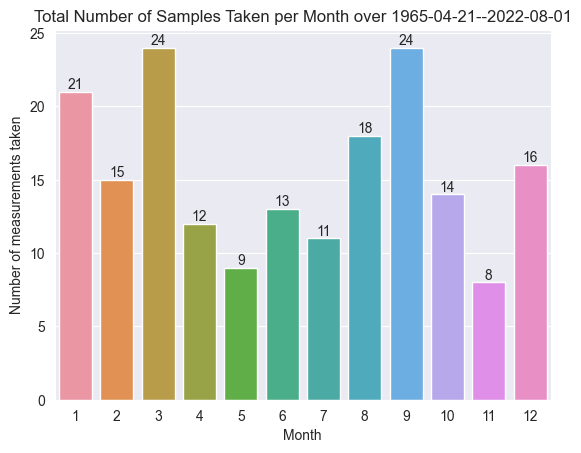

Min number of samples taken per 1 month: 0.
Max number of samples taken per 1 month 2.
Mean number of samples taken per 1 month: 0.9487179487179487.
Min number of samples taken per 1 year: 0.
Max number of samples taken per 1 year 7.
Mean number of samples taken per 1 year: 3.189655172413793.
Standard deviation of the set: 1.5697231971200192.


In [8]:
analyse_sample_data('Bsp_1.xlsx')

Name of the file: Bsp_2.xlsx
Min date is 1988-12-28.
Max date is 2022-02-02.
Total number of years discovered: 33.


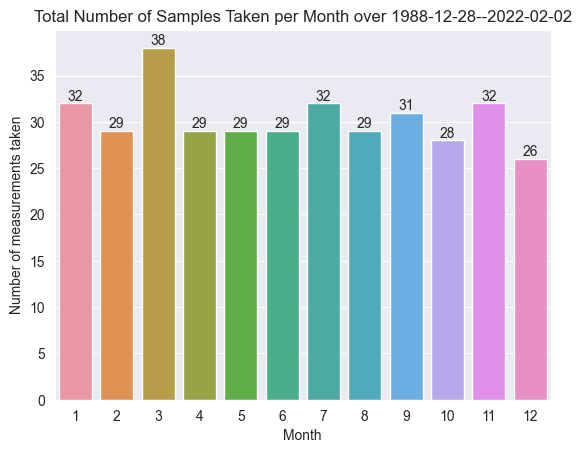

Min number of samples taken per 1 month: 1.
Max number of samples taken per 1 month 4.
Mean number of samples taken per 1 month: 1.8109452736318408.
Min number of samples taken per 1 year: 1.
Max number of samples taken per 1 year 27.
Mean number of samples taken per 1 year: 10.4.
Standard deviation of the set: 11.056219968868204.


In [9]:
analyse_sample_data('Bsp_2.xlsx')

Name of the file: Bsp_3.xlsx
Min date is 1991-05-15.
Max date is 2016-01-07.
Total number of years discovered: 24.


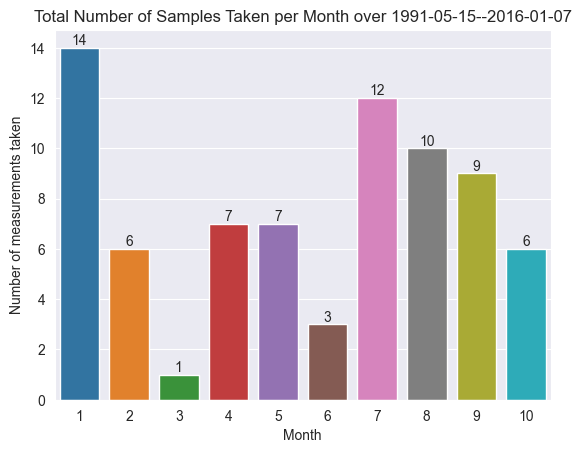

Min number of samples taken per 1 month: 0.
Max number of samples taken per 1 month 1.
Mean number of samples taken per 1 month: 0.9375.
Min number of samples taken per 1 year: 0.
Max number of samples taken per 1 year 4.
Mean number of samples taken per 1 year: 2.8846153846153846.
Standard deviation of the set: 1.1544870015233564.


In [10]:
analyse_sample_data('Bsp_3.xlsx')

Name of the file: Bsp_4.xlsx
Min date is 1973-09-20.
Max date is 2022-08-08.
Total number of years discovered: 48.


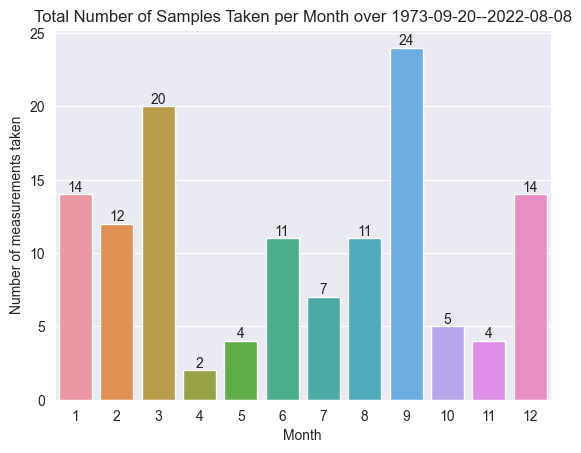

Min number of samples taken per 1 month: 0.
Max number of samples taken per 1 month 1.
Mean number of samples taken per 1 month: 0.920863309352518.
Min number of samples taken per 1 year: 0.
Max number of samples taken per 1 year 5.
Mean number of samples taken per 1 year: 2.56.
Standard deviation of the set: 1.1516944039110373.


In [11]:
analyse_sample_data('Bsp_4.xlsx')

Name of the file: Bsp_5.xlsx
Min date is 2004-08-10.
Max date is 2008-02-25.
Total number of years discovered: 3.


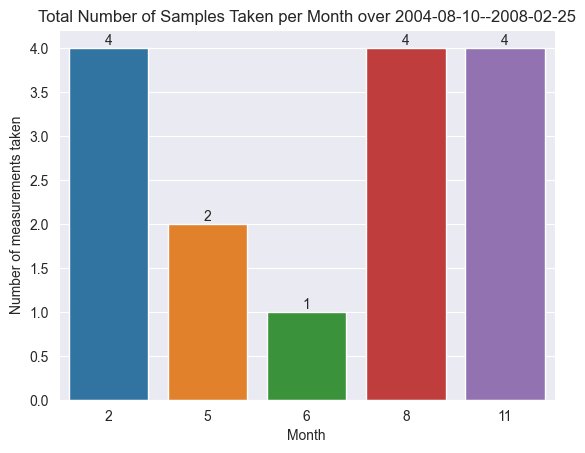

Min number of samples taken per 1 month: 1.
Max number of samples taken per 1 month 1.
Mean number of samples taken per 1 month: 1.0.
Min number of samples taken per 1 year: 1.
Max number of samples taken per 1 year 4.
Mean number of samples taken per 1 year: 3.0.
Standard deviation of the set: 1.2649110640673518.


In [12]:
analyse_sample_data('Bsp_5.xlsx')

Name of the file: Bsp_6.xlsx
Min date is 1986-02-17.
Max date is 1992-11-10.
Total number of years discovered: 6.


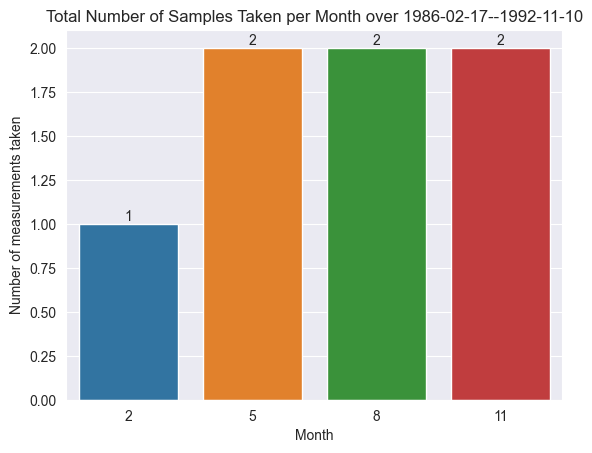

Min number of samples taken per 1 month: 0.
Max number of samples taken per 1 month 1.
Mean number of samples taken per 1 month: 0.25.
Min number of samples taken per 1 year: 0.
Max number of samples taken per 1 year 4.
Mean number of samples taken per 1 year: 1.0.
Standard deviation of the set: 1.6035674514745464.


In [13]:
analyse_sample_data('Bsp_6.xlsx')

Name of the file: Bsp_7.xlsx
Min date is 2010-06-23.
Max date is 2022-10-04.
Total number of years discovered: 12.


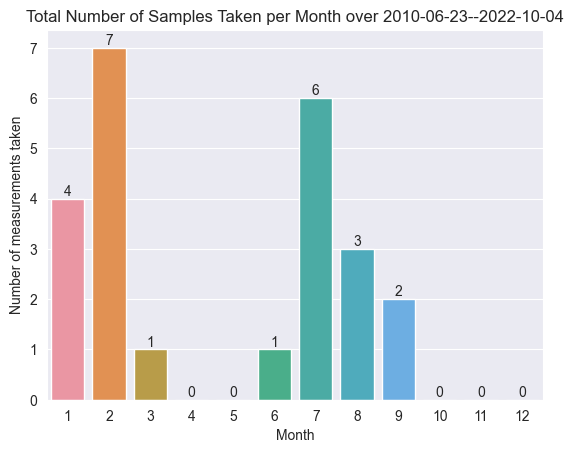

Min number of samples taken per 1 month: 0.
Max number of samples taken per 1 month 1.
Mean number of samples taken per 1 month: 0.48.
Min number of samples taken per 1 year: 1.
Max number of samples taken per 1 year 2.
Mean number of samples taken per 1 year: 1.8461538461538463.
Standard deviation of the set: 0.36080121229411.


In [14]:
analyse_sample_data('Bsp_7.xlsx')

Name of the file: Bsp_8.xlsx
Min date is 1998-09-22.
Max date is 2021-01-26.
Total number of years discovered: 22.


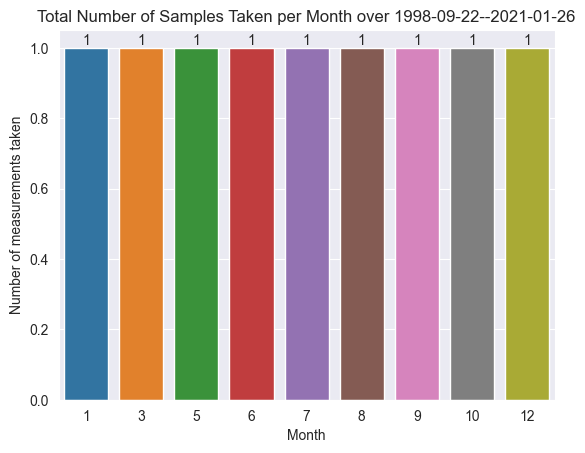

Min number of samples taken per 1 month: 1.
Max number of samples taken per 1 month 1.
Mean number of samples taken per 1 month: 1.0.
Min number of samples taken per 1 year: 1.
Max number of samples taken per 1 year 1.
Mean number of samples taken per 1 year: 1.0.
Standard deviation of the set: 0.0.


In [15]:
analyse_sample_data('Bsp_8.xlsx')